TypeError: Invalid shape (64,) for image data

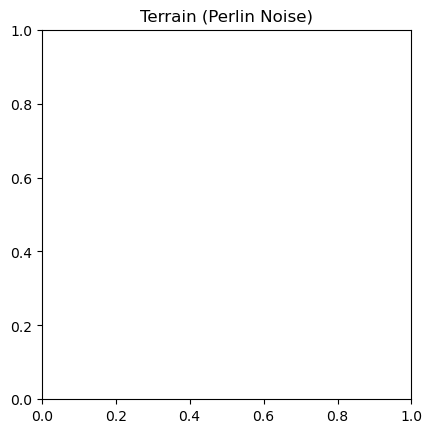

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# If you have the "noise" package installed (pip install noise),
# you can import Perlin noise functions directly:
# from noise import pnoise2
#
# Below is a small custom Perlin-like function for demonstration
# (it’s not a perfect Perlin implementation, but enough to show the concept).
# Feel free to replace it with a proper Perlin library function if available.

def perlin_noise_2d(shape, res, seed=None):
    """
    A simple pseudo-Perlin-like 2D noise function.
    shape: (height, width)
    res: (frequency_y, frequency_x)
    """
    if seed is not None:
        np.random.seed(seed)
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.random.rand(res[0] + 1, res[1] + 1)
    # Coordinate arrays
    x = np.linspace(0, res[1], shape[1], endpoint=False)
    y = np.linspace(0, res[0], shape[0], endpoint=False)
    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi

    # Four corners in each cell
    def fade(t):
        # 6t^5 - 15t^4 + 10t^3
        return 6 * t**5 - 15 * t**4 + 10 * t**3

    # Dot product approach
    n00 = grid[yi, xi]
    n10 = grid[yi, xi+1]
    n01 = grid[yi+1, xi]
    n11 = grid[yi+1, xi+1]

    u = fade(xf)
    v = fade(yf)

    x1 = n00 * (1 - u) + n10 * u
    x2 = n01 * (1 - u) + n11 * u
    return (x1 * (1 - v) + x2 * v)

def generate_heightmap(nx, ny, frequency=8, seed=None):
    """
    Generates a Perlin noise heightmap of size (ny, nx).
    frequency controls how many 'features' appear across the map.
    """
    terrain = perlin_noise_2d(shape=(ny, nx),
                              res=(frequency, frequency),
                              seed=seed)
    # Scale or shift to taste. For example, let's just scale it by 10:
    terrain *= 10.0
    return terrain

def simulate_water_diffusion(terrain, 
                             initial_water, 
                             diffusion_coefficient=0.1, 
                             dt=0.1,
                             steps=100,
                             min_water=1e-8):
    """
    Perform a simple 2D diffusion of water across terrain.
    - terrain: 2D array (ny, nx) for topography (not heavily used here, 
      but included in case you want to factor in slope or infiltration).
    - initial_water: 2D array (ny, nx) for starting water depth.
    - diffusion_coefficient: diffusion rate (D).
    - dt: time-step size.
    - steps: number of simulation steps.
    - min_water: clamp the water level to remain above this value.

    This function updates water depth in-place using a simple discrete
    approximation of the diffusion equation. 
    """
    water = initial_water.copy()
    ny, nx = water.shape

    # For a standard diffusion equation (without additional terrain slope factors):
    # water_new[i,j] = water[i,j] + D*dt*( water[i+1,j] + water[i-1,j]
    #                                      + water[i,j+1] + water[i,j-1]
    #                                      - 4*water[i,j] ) / (dx^2)
    # We assume dx=1 for simplicity.

    for _ in range(steps):
        water_new = water.copy()
        
        for i in range(1, ny - 1):
            for j in range(1, nx - 1):
                laplacian = (water[i+1, j] + water[i-1, j] +
                             water[i, j+1] + water[i, j-1]
                             - 4.0 * water[i, j])
                water_new[i, j] = water[i, j] + diffusion_coefficient * dt * laplacian

        # Clamp to ensure water depth > 0
        water_new[water_new < min_water] = min_water

        # Update
        water = water_new

    return water

if __name__ == "__main__":
    nx, ny = 64, 64  # Simulation grid dimensions
    terrain = generate_heightmap(nx, ny, frequency=8, seed=42)

    # Initialize water depth. For example, uniform water or random.
    # We'll just use a small random distribution around 1.0:
    initial_water = 1.0 + 0.01 * np.random.rand(ny, nx)

    # Simulate
    water_result = simulate_water_diffusion(terrain,
                                            initial_water,
                                            diffusion_coefficient=0.2,
                                            dt=0.1,
                                            steps=200,
                                            min_water=1e-4)

    # Visualize terrain vs. water
    plt.figure()
    plt.title("Terrain (Perlin Noise)")
    plt.imshow(terrain, origin='lower')
    plt.colorbar(label='Terrain elevation')

    plt.figure()
    plt.title("Initial Water Distribution")
    plt.imshow(initial_water, origin='lower')
    plt.colorbar(label='Water depth')

    plt.figure()
    plt.title("Water Distribution After Diffusion")
    plt.imshow(water_result, origin='lower')
    plt.colorbar(label='Water depth')

    plt.show()
